Classe Initiale : giant panda (68.32%)
Classe Adversaire : indri (45.79%)


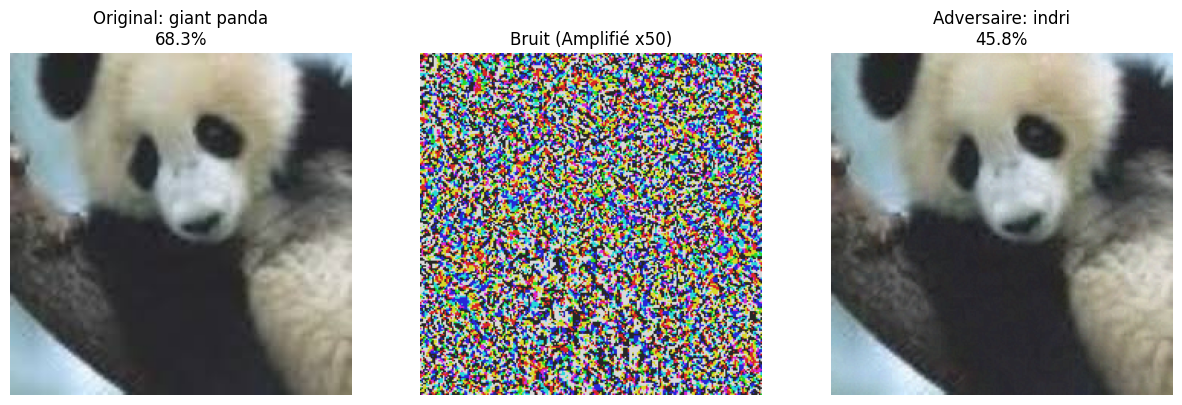

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.models import GoogLeNet_Weights
from PIL import Image
import matplotlib.pyplot as plt
import os

# Configuration du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Normalize(nn.Module):
    """
    Couche de normalisation intégrée au modèle.
    Permet à l'attaque de travailler sur des images brutes [0, 1].
    """
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        # On enregistre les constantes de normalisation comme des buffers (pas de mise à jour par gradient)
        self.register_buffer('mean', torch.Tensor(mean).view(1, 3, 1, 1))
        self.register_buffer('std', torch.Tensor(std).view(1, 3, 1, 1))
        
    def forward(self, x):
        return (x - self.mean) / self.std

def get_secured_model():
    """Charge GoogLeNet et lui ajoute la couche de normalisation en préambule."""
    base_model = models.googlenet(weights=GoogLeNet_Weights.DEFAULT)
    
    norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    model = nn.Sequential(norm_layer, base_model).to(device)
    
    model.eval()
    return model

def load_image(image_path):
    """Charge une image, la redimensionne et la convertit en tenseur [0, 1]."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"L'image {image_path} est introuvable.")
        
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(), # Transforme les pixels [0, 255] en float [0, 1]
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device) # Ajout dimension Batch
    image_tensor.requires_grad = True # Indispensable pour l'attaque
    return image_tensor

def get_prediction(model, image_tensor):
    """Retourne le nom de la classe et la confiance."""
    output = model(image_tensor)
    probs = torch.nn.functional.softmax(output, dim=1)
    
    pred_idx = probs.argmax().item()
    confidence = probs[0, pred_idx].item()
    
    weights = GoogLeNet_Weights.DEFAULT
    class_name = weights.meta["categories"][pred_idx]
    
    return pred_idx, class_name, confidence

# MAIN

model = get_secured_model()
image_tensor = load_image("panda.jpg")

init_idx, init_name, init_conf = get_prediction(model, image_tensor)
print(f"Classe Initiale : {init_name} ({init_conf*100:.2f}%)")

criterion = nn.CrossEntropyLoss()
# On calcule la perte par rapport à la prédiction initiale
loss = criterion(model(image_tensor), torch.tensor([init_idx], device=device))

model.zero_grad()
loss.backward()

# Création de l'image adverse
epsilon = 0.007
data_grad = image_tensor.grad.data
# Formule : Image + Epsilon * Signe(Gradient)
perturbed_image = torch.clamp(image_tensor + epsilon * data_grad.sign(), 0, 1)

adv_idx, adv_name, adv_conf = get_prediction(model, perturbed_image)
print(f"Classe Adversaire : {adv_name} ({adv_conf*100:.2f}%)")

plt.figure(figsize=(15, 5))

# Image Originale
plt.subplot(1, 3, 1)
plt.title(f"Original: {init_name}\n{init_conf*100:.1f}%")
plt.imshow(image_tensor.detach().cpu().squeeze().permute(1, 2, 0))
plt.axis('off')

# Bruit (Amplifié)
plt.subplot(1, 3, 2)
plt.title("Bruit (Amplifié x50)")
noise = (perturbed_image - image_tensor).detach().cpu().squeeze().permute(1, 2, 0)
plt.imshow((noise * 50 + 0.5).clamp(0, 1)) # Astuce d'affichage
plt.axis('off')

# Image Adversaire
plt.subplot(1, 3, 3)
plt.title(f"Adversaire: {adv_name}\n{adv_conf*100:.1f}%")
plt.imshow(perturbed_image.detach().cpu().squeeze().permute(1, 2, 0))
plt.axis('off')

plt.show()